# Example 1d: Interpret relative moment tensor results

This example illustrates how to interpret relative moment tensors. It relies on the results of the previous example 1c.

First, we import everything we need for this tutorial to work.

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from relmt import io, mt, utils
from pyrocko.moment_tensor import MomentTensor
from pyrocko.plot import beachball
from itertools import cycle
from IPython.display import display # trick to show files in notebook

## Different reference yields different results, but not very

As with relative event locations, the quality of relative moment tensors depend on the quality of their absolute reference. The results can't be better than the reference you are parsing. Relative moment tensors are best defined for events of similar magnitude. This owes to the fact that the relative amplitudes are measured within a common frequency band below the corner frequency of the larger event and that noisy frequencies should be avoided. For illustration, let us consider the figures created in the previous example.

The left image shows the resulting relative MTs using as reference the smaller event *7508* ($M_W = 4.1$), the right image with the larger event *7640* ($M_W = 5.0$). Both images are colored by the RMS of the Kagan angles of all bootstrap realizations, larger numbers indicate less stable (reliable) results. The reference MT is highlighted with red outlines. Double couple components > 20% are superimposed as lines. 

<img
    src="https://raw.githubusercontent.com/wasjabloch/relMT-data/main/example/ref7508.png"
    width=49% align="left"
/>

<img
    src="https://raw.githubusercontent.com/wasjabloch/relMT-data/main/example/ref7640.png"
    width=49% align="right"
/>

### Qualitative comparison between results

We see in the figure above that both realizations yield similar results. The majority of the events are of strike-slip faulting type. A few moment tensors indicate normal faulting, a few reverse faulting. We recognize that the strike-slip events tend to resemble the reference MT, that is, in the left figure they are almost purely strike slip, while in the right figure they exhibit a slight normal-faulting component.

Some properties of the results indicate that it is favorable to use the smaller event *7508* as a reference (left), instead of the  larger event (*7640*, right). When using the smaller event, we see that all but one MT (*8135*) have a DC component > 20%, while when using the larger event, we find 3 such MTs. As we are looking at tectonic earthquakes, we would expect the results to have a large DC component. Additionally, the maximum Kagan angle RMS is about 20° for the *7508* reference, while it is 27° for the *7640* reference, indicating less stable results.

Between both images there is a trend that the more an individual MT result differs dependent on the choice of reference MT (between left and right), the higher the Kagan angle RMS. This indicates that the Kagan RMS is a good measure for detecting outliers. One important exception from this correlation is event *3384*, which is a normal faulting event in the left figure, but a strike slip event in the right figure. Both faulting types occur again in the data set, so neither MT can be declared as an outlier.

### Outlier exclusion
We will next take a closer look at the Kagan RMS and the Moment RMS of the bootstrapping results. Let us define a scatter plot with histograms along the X- and Y axis.


In [29]:
def plot_bootstrap(x_kagan, y_moment, names, iout):
    """Plot scatter with marginal histograms, show names of outliers."""

    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(
        2, 2, width_ratios=(4, 1), height_ratios=(1, 4), wspace=0.05, hspace=0.05
    )

    # Scatter and historgram axes
    axs = fig.add_subplot(gs[1, 0])
    axx = fig.add_subplot(gs[0, 0], sharex=axs)
    axy = fig.add_subplot(gs[1, 1], sharey=axs)

    # Scatter plot
    axs.scatter(x_kagan, y_moment, s=10)

    # Name outliers
    for out in iout.nonzero()[0]:
        axs.text(x_kagan[out], y_moment[out], int(names[out]), ha="right")

    # Histograms
    axx.hist(x_kagan, bins=30)
    axy.hist(y_moment, bins=30, orientation="horizontal")

    # Clean up
    axx.tick_params(labelbottom=False)
    axy.tick_params(labelleft=False)
    axx.spines[["top", "right", "left"]].set_visible(False)
    axy.spines[["top", "right", "bottom"]].set_visible(False)

    axs.set_ylabel("Kagan angle RMS (°)")
    axs.set_xlabel("relative moment RMS (Nm/M0)")
    axs.set_xlim((0, 0.7))
    axs.set_ylim((0, 32))


In [30]:
# Show both events in a cycle
plot_event = cycle([7508, 7640])

We plot both events one after another and recognize how event *7508* has better (lower) Kagan and Moment RMS values. Execute the next cell again to plot the other event.

Plotting event 7508


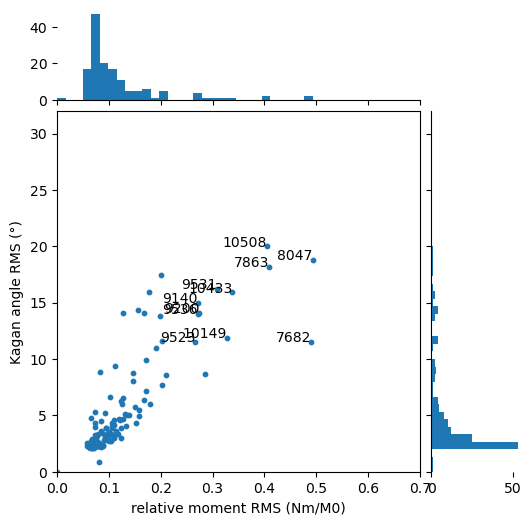

In [49]:
# Iterate through events
evn = next(plot_event)
mtfile = f"muji/result/mt_summary-auto-admitted-{evn}.txt"

print(f"Plotting event {evn}")

# Load the file
evns, moment_rms, kagan_rms = np.loadtxt(mtfile, usecols=(0, 22, 23), unpack=True)

# Define outliers
iout = (moment_rms > 0.25) & (kagan_rms > 10)

# Plot with the above defined function
plot_bootstrap(moment_rms, kagan_rms, evns, iout)

## Exclude outliers
We will continue working with our preferred dataset from event *7508*. We first exclude the outlying MTs.

In [50]:
mtfile = "muji/result/mt_summary-auto-admitted-7508.txt"
mtdata = np.loadtxt(mtfile)


# Extract kagan and moment RMS
kagan_rms, moment_rms = mtdata[:, 22], mtdata[:, 23]

mtd = io.read_mt_table(mtfile)
evns = np.array(list(mtd.keys()))

# Remove outliers
iout = (moment_rms > 0.25) & (kagan_rms > 10)

# Index array and event names of inliers
iin = (~iout).nonzero()[0]
evns = evns[iin]

# All events in the complete catalog
evd = io.read_event_table("data/events.txt")

# Events with moment tensors
mtev = {evn: evd[evn] for evn in evns}
mtd = {evn: mtd[evn] for evn in evns}

print(f"Selected {len(mtev)} events with relative MTs")

Selected 136 events with relative MTs


## Group events by faulting type
Next we group the moment tensors by faulting type. The unclustered events receive the label *0*, while the other labels are sorted by the number of associated events.

In [74]:
# Cluster labels in order of input catalog
labels, *_ = utils.mt_clusters(
    list(mtd.values()),  # Moment tensors defined by their position in the list
    method="kagan",  # Cluster events by Kagan angle
    distance_matrix=None,  # Pre-computed distance matrix for large datasets
    max_distance=40,  # Maximal distance (Kagan angle) for one cluster
    min_ev=2,  # Minimum number of events to form a cluster
    link_method="weighted",  # Method to combine events
)

# Unique labels
ulab = sorted(set(labels))

print(f"Grouped events into {len(set(labels))} faulting types:")
print(", \n".join([f"Type {lab}: {sum(labels==lab)} events" for lab in ulab]))


Grouped events into 5 faulting types:
Type 0: 5 events, 
Type 1: 115 events, 
Type 2: 9 events, 
Type 3: 4 events, 
Type 4: 3 events


## Plot events in map view
We will now plot the events on a map and color them by their faulting type. We will plot the catalog of the entire aftershock sequence in the background to get some tectonic context. The origin of our plot will be the location of the reference event. We first transform the data into practical coordinates and assign colors to the faulting types. We then set up the figure and plot everything.

In [75]:
# Select the reference event from the catalog
iref = 7508
rev = evd[iref]

# Origin north, east, depth coordinate
ned0 = np.array([rev.north, rev.east, rev.depth])

# Whole catalog and moment tensor north and east coordinates
ev_ned = (utils.xyzarray(evd) - ned0) * 1e-3
mt_ned = (utils.xyzarray(mtev) - ned0) * 1e-3

print("Spatial extent of events:")
print(
    f"North: {min(mt_ned[:, 0]) :.1f} to {max(mt_ned[:, 0]) :.1f} km, ",
    f"East: {min(mt_ned[:, 1]) :.1f} to {max(mt_ned[:, 1]) :.1f} km"
)

# Color map for faulting types
mtc = {lab: cm.Dark2_r(frac) for lab, frac in zip(ulab, np.linspace(0.0, 1.0, len(ulab)))}

# Legend entries
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label=f"{lab} ({sum(labels==lab)})",
        markerfacecolor=col,
        markersize=5,
    )
    for lab, col in mtc.items()
]

Spatial extent of events:
North: -3.1 to 4.4 km,  East: -6.0 to 2.6 km


We will first draw where we have started...

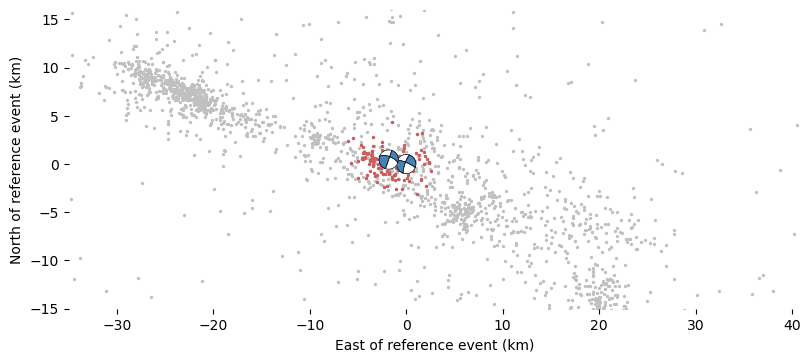

In [76]:
# Select the reference event from the catalog
iref = 7508
rev = evd[iref]

# Create the figure
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")

# Map coordinates
ax.set_xlim((-35, 41))
ax.set_ylim((-15, 16))
ax.set_aspect("equal")
ax.set_xlabel("East of reference event (km)")
ax.set_ylabel("North of reference event (km)")
ax.spines[:].set_visible(False)

# All events in the background
ax.scatter(*ev_ned[:, [1, 0]].T, s=2, color="silver", zorder=-5)

# Selected events
ax.scatter(*mt_ned[:, [1, 0]].T, s=2, color="indianred", zorder=0)

# Moment tensor plotting
mtsize = 2 # Size of the beachball in km

# Plot the reference moment tensors
for evn in [7508, 7640]:

    # Get moment tensor and event
    momt = mtd[evn]
    ev = evd[evn]

    # Event coordinates relative to reference event in km
    ned = (np.array([ev.north, ev.east, ev.depth]) - ned0) *1e-3

    # Convert to Pyrocko moment tensor
    thismt = MomentTensor(mt.mt_array(momt))

    # The beachball
    beachball.plot_beachball_mpl(
        thismt,
        ax,
        beachball_type="dc",
        size=mtsize,
        position=(ned[1], ned[0]),
        color_t="steelblue",
        linewidth=0.5,
        size_units="data",
    )

fig.savefig("relmt_begin.pdf")

... and now see how far we've got!

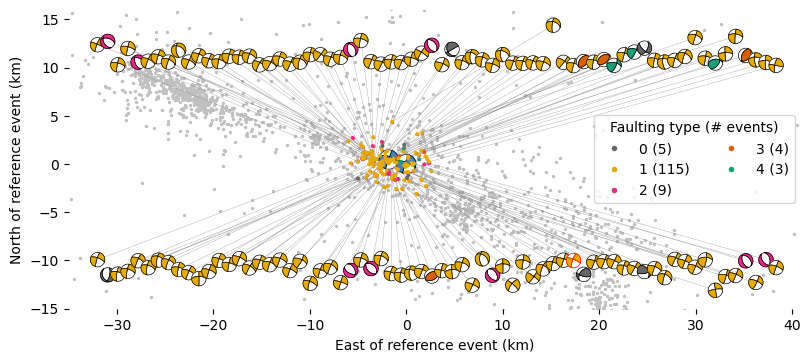

In [77]:

# Events with MTs colored by faulting type
ax.scatter(*mt_ned[:, [1, 0]].T, s=3, c=[mtc[lab] for lab in labels], zorder=5)

# The legend
ax.legend(title="Faulting type (# events)", handles=handles, ncol=2)

# Moment tensor plotting
mtsize = 1.5 # Size of the beachball in km
de = 0.7 * mtsize  # East offset for each MT

# East start coordinate of top and bottom MT row
east_top = -32
east_bot = -32

# North offset of top and bottom MT row
north_top = 10
north_bot = -10

# Sort from east to west for better display
esort = np.argsort(mt_ned[:, 1])

# Plot the moment tensors
for ii, ie in enumerate(esort):
    
    # Get name and faulting type of the event
    evname = evns[ie]
    lab = labels[ie]

    # Get moment tensor and event
    momt = mtd[evname]
    ev = evd[evname]

    # Event coordinates relative to reference event in km
    eve, evn = mt_ned[ie, [1, 0]]

    # Choose to plot in top or bottom row
    if evn > 0.2:
        e = east_top
        n = evn + north_top
        east_top += de
    else:
        e = east_bot
        n = evn + north_bot
        east_bot += de

    # Highlight the reference event
    outline = "black"
    if evname == iref:
        outline = "red"

    # Convert to Pyrocko moment tensor
    thismt = MomentTensor(mt.mt_array(momt))

    # Color by faulting type
    color_t = mtc[lab]

    # Connecting line
    ax.plot([eve, e], [evn, n], color="gray", linewidth=0.2, zorder=-1)

    # The beachball
    beachball.plot_beachball_mpl(
        thismt,
        ax,
        beachball_type="dc",
        size=mtsize,
        position=(e, n),
        color_t=color_t,
        linewidth=0.5,
        edgecolor=outline,
        size_units="data",
    )
fig.savefig("relmt_finish.pdf")

display(fig)

Nice!

We see that 115 of the events (*1*) are of the right-lateral faulting type of the main shock. However, a significant number of other faulting types is present: 9 normal faulting events (*2*) align along the main fault trace delineated by all aftershocks (*gray*). 4 reverse faulting (*3*) and 3 transpressional events (*5*) cluster at the eastern rim of the cluster, i.e. the western rim of the eastern asperity. Additionally, we find 5 unclustered events (*0*)

## Magnitude comparison

The relative moment tensors also provide a moment magnitude estimate($M_W$) of each of the events. Let us compute it and compare to the local magnitude ($M_L$) provided in the catalog.

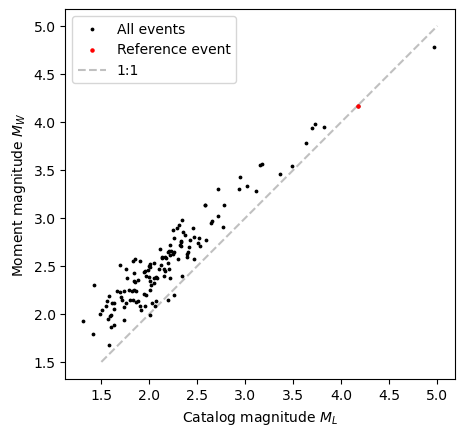

In [ ]:
ml = [evd[evn].mag for evn in mtd]
mw = [mt.magnitude_of_vector(momt) for momt in mtd.values()]

fig, ax = plt.subplots()
ax.scatter(ml, mw, s=3, c="black", label="All events")
ax.scatter(evd[iref].mag, mt.magnitude_of_vector(mtd[iref]), s=5, c="red", label="Reference event")
ax.plot([1.5, 5], [1.5, 5], color="silver", linestyle="--", label="1:1", zorder=-1)
ax.set_xlabel("Catalog magnitude $M_L$ ($M_W$ for the two larges events)")
ax.set_ylabel("Moment magnitude $M_W$")
ax.set_aspect("equal")
_ = ax.legend()


These are our newly determined relative moment magnitudes! The reference event plots on the 1:1 line, as it should be. For the other events, it appears as if the local magnitude $M_L$ consistently underestimated the seismic moment, especially at $M_L < 3.5$.

## Conclusion
This tutorial demonstrated the interpretation of relative seismic moment tensors. We learned how to judge the quality of a relative MT, and how to exclude outlying observations. We finally looked into the faulting types and moment magnitudes.